In [1]:
import os
from glob import glob
from PIL import Image

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
X_train = np.load("../input/256-192-dataset/256_192_train.npy")
y_train = np.load("../input/256-192-dataset/train_labels.npy")
X_val = np.load("../input/256-192-dataset/256_192_val.npy")
y_val = np.load("../input/256-192-dataset/val_labels.npy")

In [3]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [4]:
pre_trained_model = VGG19(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

2022-04-03 12:13:02.201437: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 12:13:02.317207: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 12:13:02.318321: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-03 12:13:02.320156: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

80150528/80134624 [==============================] - 2s 0us/step


In [5]:
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
22


In [6]:
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 6, 8, 512)


In [7]:
# Flatten the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(7, activation='softmax')(x)

# Configure and compile the model

model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [8]:
train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10)

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [9]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [10]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [11]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [12]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 64, 128)       0     

In [13]:
batch_size = 64
epochs = 40
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size),
                              validation_steps=(X_val.shape[0] // batch_size),
                              callbacks=[learning_rate_reduction])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-04-03 12:14:08.235118: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.
2022-04-03 12:14:08.380526: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-04-03 12:14:10.575822: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.
2022-04-03 12:14:11.455619: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.
2022-04-03 12:14:11.571255: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  2/126 [..............................] - ETA: 54s - loss: 2.5102 - acc: 0.0938  

2022-04-03 12:14:24.785026: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.


  3/126 [..............................] - ETA: 1:20 - loss: 2.1956 - acc: 0.2240

2022-04-03 12:14:25.649126: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 37748736 exceeds 10% of free system memory.


126/126 [==============================] - 137s 971ms/step - loss: 1.0967 - acc: 0.6548 - val_loss: 0.8463 - val_acc: 0.7143
Epoch 2/40
126/126 [==============================] - 115s 908ms/step - loss: 0.8939 - acc: 0.6898 - val_loss: 0.8905 - val_acc: 0.6696
Epoch 3/40
126/126 [==============================] - 112s 886ms/step - loss: 0.8138 - acc: 0.7118 - val_loss: 0.7897 - val_acc: 0.6942
Epoch 4/40
126/126 [==============================] - 113s 892ms/step - loss: 0.7882 - acc: 0.7134 - val_loss: 0.7923 - val_acc: 0.6987

Epoch 00004: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
Epoch 5/40
126/126 [==============================] - 114s 902ms/step - loss: 0.7118 - acc: 0.7425 - val_loss: 0.6600 - val_acc: 0.7478
Epoch 6/40
126/126 [==============================] - 113s 893ms/step - loss: 0.6755 - acc: 0.7569 - val_loss: 0.7183 - val_acc: 0.7500
Epoch 7/40
126/126 [==============================] - 113s 898ms/step - loss: 0.6426 - acc: 0.7614 - val_loss: 0.7

In [14]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 3s 92ms/step - loss: 0.5604 - acc: 0.8171
Validation: accuracy = 0.817073  ;  loss_v = 0.560399


In [15]:
X_test = np.load("../input/256-192-dataset/256_192_test.npy")
y_test = np.load("../input/256-192-dataset/test_labels.npy")

y_test = to_categorical(y_test)


NameError: name 'test_datagen' is not defined

In [16]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 3s 102ms/step - loss: 0.5986 - acc: 0.8004
Test: accuracy = 0.800399  ;  loss = 0.598608


In [17]:
model.save("./vgg16.h5")

In [18]:
y_pred=model.predict_generator(X_test)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
K.int_shape(y_pred)

(1002, 7)

In [20]:
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[  8   4  10   0   2   0   4]
 [  1  37   7   2   9   0   1]
 [  2   4  62   0  27   0  13]
 [  2   2   6   2   2   0   1]
 [  0   2  25   1 632   0  18]
 [  0   2   0   1   1   9   1]
 [  4   1   9   0  36   0  52]]


In [21]:
target_names = ['class 0', 'class 1', 'class 2', 'class 3', 'class 4', 'class 5', 'class 6']

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.47      0.29      0.36        28
     class 1       0.71      0.65      0.68        57
     class 2       0.52      0.57      0.55       108
     class 3       0.33      0.13      0.19        15
     class 4       0.89      0.93      0.91       678
     class 5       1.00      0.64      0.78        14
     class 6       0.58      0.51      0.54       102

    accuracy                           0.80      1002
   macro avg       0.64      0.53      0.57      1002
weighted avg       0.79      0.80      0.79      1002



dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


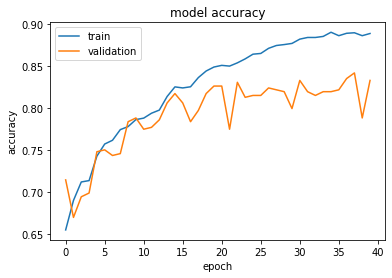

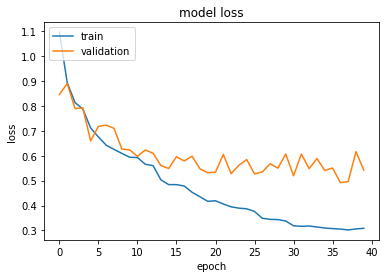

In [23]:
# summarize history for accuracy
print(history.history.keys())
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
#plt.plot(history.history['test_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation','test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(history.history['test_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation','test'], loc='upper left')
plt.show()


In [24]:
from imblearn.metrics import sensitivity_specificity_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
result = sensitivity_specificity_support(y_test,y_pred,average='macro' )

print("Sensitivity: {:5.2f}%".format(100*result[0]), "specificity {:5.2f}%".format(100*result[1]))

Sensitivity: 53.24% specificity 94.67%


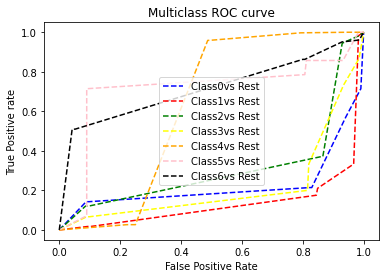

In [25]:
# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 7

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(y_test, y_pred, pos_label=i)
    
# plotting

colors=['blue','red','green','yellow','orange','pink','black']

for i in range(0,7):
    plt.plot(fpr[i], tpr[i], linestyle='--',color=colors[i], label='Class'+ str(i) +'vs Rest')


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);